In [1]:
# imports
import os
import math
import random
import torch
from torch.utils.data import Dataset, DataLoader
import torchaudio
import numpy as np
import moviepy.editor as mped
import matplotlib.pyplot as plt
import IPython
from IPython.display import Audio

DEVICE = 'cuda'

/home/alex/.local/lib/python3.9/site-packages/torchaudio/backend/utils.py:53: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  warnings.warn(


In [2]:
# dataset
class AudioDataset(Dataset):
    # Constructor
    def __init__(self, path, dataset = 'train', chunk_size = 4, chunk_step = 1/40, sr = 22050,
                 frame_length = 1024, win_length = 1024, hop_length = 512, use_mel = True, mel_count = 128,
                 keep_audio = True, use_wobble = True, wobble = 2):
        self.path = path
        self.chunk_size = chunk_size
        self.chunk_step = chunk_step
        self.sr = sr
        self.frame_length = frame_length
        self.win_length = win_length
        self.hop_length = hop_length
        self.use_mel = use_mel
        self.mel_count = mel_count
        self.pos_audio = None
        self.neg_audio = None
        self.keep_audio = keep_audio
        self.use_wobble = use_wobble
        self.wobble = wobble
        
        def get_file(file):
            video = mped.VideoFileClip(file)
            audio = video.audio
            audio_tensor = torch.Tensor(audio.to_soundarray(fps=self.sr, nbytes=2)).t()
            video.close()
            audio.close()
            audio_tensor = torch.mean(audio_tensor, dim=0, keepdim=True) # Stereo to mono

            return audio_tensor
        
        print('Loading audio into memory')
        labels = ['Negative', 'Positive']
        for label in labels:
            for root, directories, files in os.walk(os.path.join(self.path, dataset.capitalize(), label), topdown=False):
                for file in files:
                    if file.endswith('.mp4'):
                        try :
                            if label == 'Positive':
                                if self.pos_audio is None:
                                    self.pos_audio = get_file(os.path.join(root, file))
                                elif torch.is_tensor(self.pos_audio):
                                    audio = get_file(os.path.join(root, file))
                                    self.pos_audio = torch.cat((self.pos_audio, audio), 1)
                            elif label == 'Negative':
                                if self.neg_audio is None:
                                    self.neg_audio = get_file(os.path.join(root, file))
                                elif torch.is_tensor(self.neg_audio):
                                    audio = get_file(os.path.join(root, file))
                                    self.neg_audio = torch.cat((self.neg_audio, audio), 1)
                        except :
                            print(f'Error loading {os.path.join(root, file)}')

        print('Finished loading audio into memory')
        self.pos_audio_len = int(math.ceil(self.pos_audio.shape[1] / (self.chunk_step * self.sr))
                                 - (self.chunk_size / self.chunk_step))
        self.neg_audio_len = int(math.ceil(self.neg_audio.shape[1] / (self.chunk_step * self.sr))
                                 - (self.chunk_size / self.chunk_step))
        
        print('Generating positive spectogram')
        self.pos_spectogram = self.get_spectogram(self.pos_audio)
        if not self.keep_audio:
            self.pos_audio = None
        print('Generating negative spectogram')
        self.neg_spectogram = self.get_spectogram(self.neg_audio)
        if not self.keep_audio:
            self.neg_audio = None
        
        #total_spectogram = torch.cat((self.pos_spectogram, self.neg_spectogram), 2)
        #self.spec_mean = torch.mean(total_spectogram)
        #self.spec_std = torch.std(total_spectogram)
        #total_spectogram = None
        #print(f'Dataset mean = {self.spec_mean:.4f} std = {self.spec_std:.4f}')
        
        # hard coding mean and std for my dataset
        if use_mel:
            self.spec_mean = -16.5 # mel spectogram
            self.spec_std = 14.5 # mel spectogram
        else:
            self.spec_mean = -30 # spectogram
            self.spec_std = 15 # spectogram
        
        self.pos_spectogram = (self.pos_spectogram - self.spec_mean) / self.spec_std
        self.neg_spectogram = (self.neg_spectogram - self.spec_mean) / self.spec_std
    
    def get_spectogram(self, audio):
        if self.use_mel:
            spectogram = torchaudio.transforms.MelSpectrogram(sample_rate = self.sr,
                                                                n_fft = self.frame_length,
                                                                win_length = self.win_length,
                                                                hop_length = self.hop_length,
                                                                n_mels = self.mel_count,
                                                                window_fn = torch.hamming_window)(audio)
        else:  
            window = torch.hamming_window(self.win_length, requires_grad=False)
            spectogram = torchaudio.functional.spectrogram(audio,
                                                            pad = 0,
                                                            n_fft = self.frame_length,
                                                            win_length = self.win_length,
                                                            hop_length = self.hop_length,
                                                            window = window,
                                                            power = 2,
                                                            normalized = False)
            
        spectogram = torchaudio.functional.amplitude_to_DB(spectogram,
                                                            amin = 1e-10,
                                                            multiplier = 10.0,
                                                            db_multiplier = 0)
        
        return spectogram
    
    # Get the length
    def __len__(self):
        return self.pos_audio_len + self.neg_audio_len
    
    # Getter
    def __getitem__(self, idx):
        wobble = random.randint(0,self.wobble)
        
        if(idx >= self.pos_audio_len):
            start = math.ceil((idx - self.pos_audio_len) * self.chunk_step * self.sr)
            if self.use_wobble:
                start += wobble * self.hop_length
            if self.keep_audio:
                end = math.ceil(start + self.chunk_size * self.sr)
                audio = self.neg_audio[:,start:end]

            start_spectogram = math.floor(start / self.hop_length)
            end_spectogram = math.floor(start_spectogram + (self.chunk_size * self.sr) / self.hop_length)
            spectogram = self.neg_spectogram[:,:,start_spectogram:end_spectogram]

            label = 0.
        else:
            start = math.ceil(idx * self.chunk_step * self.sr)
            if self.use_wobble:
                start += wobble * self.hop_length
            if self.keep_audio:
                end = math.ceil(start + self.chunk_size * self.sr)
                audio = self.pos_audio[:,start:end]
            
            start_spectogram = math.floor(start / self.hop_length)
            end_spectogram = math.floor(start_spectogram + (self.chunk_size * self.sr) / self.hop_length)
            spectogram = self.pos_spectogram[:,:,start_spectogram:end_spectogram]

            label = 1.
        if self.keep_audio:
            audio = audio.squeeze(0)
        else:
            audio = torch.tensor([0])
        spectogram = spectogram.squeeze(0)

        if self.keep_audio:
            if audio.shape[0] < self.chunk_size * self.sr:
                pad = torch.zeros(self.chunk_size * self.sr)
                pad[:audio.shape[0]] = audio
                audio = pad
        spec_length = math.floor((self.chunk_size * self.sr) / self.hop_length)
        if spectogram.shape[1] < spec_length:
            pad = torch.zeros(spectogram.shape[0], spec_length)
            pad[:,:spectogram.shape[1]] = spectogram
            spectogram = pad
        
        return spectogram, audio, label

In [3]:
# model class
class LSTM(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_outputs, dropout = 0.2):
        super(LSTM, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.lstm = torch.nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        # x -> batch_size, sequence_length, input_size
        self.batchnorm = torch.nn.BatchNorm1d(hidden_size)
        self.fc = torch.nn.Linear(hidden_size, num_outputs)
        self.sigmoid = torch.nn.Sigmoid()
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(DEVICE)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(DEVICE)
        
        out, _ = self.lstm(x, (h0, c0))
        # out: batch_size, sequence_length, hidden_size
        # out: (N, 88, 1024)
        out = out[:, -1, :]
        # out (N, 1024) i.e. Take the last in the sequence only
        out = self.batchnorm(out)
        out = self.fc(out)
        out = self.sigmoid(out)
        return out

In [4]:
# model class
class CNN(torch.nn.Module):
    def __init__(self, height, width, kernel_size=5, dropout=0.1):
        super(CNN, self).__init__()
        
        def get_flat_size(c,h,w,k,s=1,p=0):
            # first conv
            new_w = math.ceil((w-k+2*p)/s+1)
            new_h = math.ceil((h-k+2*p)/s+1)
            new_c = c * 4
            # max pool
            new_w = math.floor(new_w / 2)
            new_h = math.floor(new_h / 2)
            # second conv
            new_w = math.ceil((new_w-k+2*p)/s+1)
            new_h = math.ceil((new_h-k+2*p)/s+1)
            new_c = new_c * 2
            # max pool
            new_w = math.floor(new_w / 2)
            new_h = math.floor(new_h / 2)
            # third conv
            new_w = math.ceil((new_w-k+2*p)/s+1)
            new_h = math.ceil((new_h-k+2*p)/s+1)
            new_c = new_c * 2

            flat_size = new_w * new_h * new_c

            return flat_size
        
        input_channels = 1
        outputs = 1
        self.activation = torch.nn.ReLU()
        self.conv1 = torch.nn.Conv2d(input_channels, input_channels * 4, kernel_size=kernel_size)
        self.maxpool1 = torch.nn.MaxPool2d(2)
        self.conv2 = torch.nn.Conv2d(input_channels * 4, input_channels * 8, kernel_size=kernel_size)
        self.maxpool2 = torch.nn.MaxPool2d(2)
        self.conv3 = torch.nn.Conv2d(input_channels * 8, input_channels * 16, kernel_size=kernel_size)
        self.dropout1 = torch.nn.Dropout(p=dropout)
        self.flat_size = get_flat_size(input_channels,height,width,kernel_size)
        self.fc1 = torch.nn.Linear(self.flat_size, self.flat_size)
        self.dropout2 = torch.nn.Dropout(p=dropout)
        self.fc2 = torch.nn.Linear(self.flat_size, outputs)
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, x):
        x = x.unsqueeze(1) # Add channel dim
        batch_size = x.shape[0]
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.activation(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.activation(x)
        x = self.conv3(x)
        x = self.activation(x)
        x = x.view(batch_size, self.flat_size) 
        x = self.dropout1(x)
        x = self.fc1(x)
        x = self.activation(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        
        return x
        

In [6]:
# hyperparameters
chunk_size = 5 # seconds
chunk_step = 1/40 # seconds
use_wobble = True
wobble = 1 # wobbles the dataset by 0 or 1 hop randomly (no point increasing this unless chunk_step is reduced)
sr = 22050 # Hz
frame_length = 2048 # samples
win_length = 2048 # samples
hop_length = 1024 # samples
use_mel = True
mel_count = 128
if use_mel:
    input_size = mel_count
else:
    input_size = math.ceil((frame_length / 2) + 1)
hidden_size = 512
sequence_length = math.floor((chunk_size * sr) / hop_length)
num_layers = 1
num_outputs = 1
num_epochs = 100
batch_size = 256
learning_rate = 0.0001
dropout = 0.5
kernel_size = 5 # for CNN
threshold = 0.999
model_type = 'cnn' # or 'lstm'
model_file = 'model.pth'

In [7]:
# model, loss function and optimiser
if model_type == 'lstm':
    model = LSTM(input_size, hidden_size, num_layers, num_outputs, dropout).to(DEVICE)
elif model_type == 'cnn':
    model = CNN(height=input_size, width=sequence_length, kernel_size=kernel_size, dropout=dropout).to(DEVICE)
if os.path.isfile(model_file):
    try:
        state_dict = torch.load(model_file)
        model.load_state_dict(state_dict) ## Will this work?
    except:
        print('Failed to load saved model')
print(model)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

CNN(
  (activation): ReLU()
  (conv1): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(4, 8, kernel_size=(5, 5), stride=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=7600, out_features=7600, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=7600, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [8]:
# training and test sets
train_dataset = None # frees up some memory when re-running this cell
test_dataset = None # frees up some memory when re-running this cell
train_dataset = AudioDataset('Data',
                             dataset = 'train',
                             chunk_size = chunk_size,
                             chunk_step = chunk_step,
                             sr = sr,
                             frame_length = frame_length,
                             win_length = win_length,
                             hop_length = hop_length,
                             use_mel = use_mel,
                             mel_count = mel_count,
                             keep_audio = True,
                             use_wobble = use_wobble,
                             wobble = wobble)

test_dataset = AudioDataset('Data',
                             dataset = 'test',
                             chunk_size = chunk_size,
                             chunk_step = chunk_step,
                             sr = sr,
                             frame_length = frame_length,
                             win_length = win_length,
                             hop_length = hop_length,
                             use_mel = use_mel,
                             mel_count = mel_count,
                             keep_audio = True,
                             use_wobble = use_wobble,
                             wobble = wobble)

Loading audio into memory
Finished loading audio into memory
Generating positive spectogram
Generating negative spectogram
Loading audio into memory
Finished loading audio into memory
Generating positive spectogram
Generating negative spectogram


In [9]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

Epoch [1/100], Step [100/7699], Loss: 0.289934903383
Epoch [1/100], Step [200/7699], Loss: 0.183582901955
Epoch [1/100], Step [300/7699], Loss: 0.127149567008
Epoch [1/100], Step [400/7699], Loss: 0.135607391596
Epoch [1/100], Step [500/7699], Loss: 0.115236073732
Epoch [1/100], Step [600/7699], Loss: 0.069886609912
Epoch [1/100], Step [700/7699], Loss: 0.108125030994
Epoch [1/100], Step [800/7699], Loss: 0.119780570269
Epoch [1/100], Step [900/7699], Loss: 0.088927403092
Epoch [1/100], Step [1000/7699], Loss: 0.060670591891
TRAIN SET
Accuracy: 0.76171875
True Positive: 12.0
True Negative: 183.0
False Positive: 0.0
False Negative: 61.0
TEST SET
Accuracy: 0.875
True Positive: 5.0
True Negative: 219.0
False Positive: 0.0
False Negative: 32.0
Epoch [1/100], Step [1100/7699], Loss: 0.063304945827
Epoch [1/100], Step [1200/7699], Loss: 0.087966695428
Epoch [1/100], Step [1300/7699], Loss: 0.089802756906
Epoch [1/100], Step [1400/7699], Loss: 0.053190886974
Epoch [1/100], Step [1500/7699], L

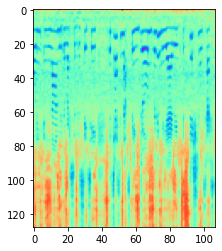

False Positive Example:
Score: 1.0


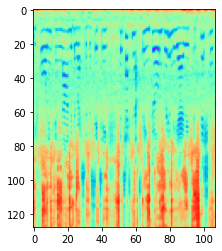

False Negative: 9.0
Epoch [2/100], Step [4100/7699], Loss: 0.001241883612
Epoch [2/100], Step [4200/7699], Loss: 0.001455233200
Epoch [2/100], Step [4300/7699], Loss: 0.000721696531
Epoch [2/100], Step [4400/7699], Loss: 0.005755756982
Epoch [2/100], Step [4500/7699], Loss: 0.003507123794
Epoch [2/100], Step [4600/7699], Loss: 0.000299395586
Epoch [2/100], Step [4700/7699], Loss: 0.002941854764
Epoch [2/100], Step [4800/7699], Loss: 0.000455712259
Epoch [2/100], Step [4900/7699], Loss: 0.000871499884
Epoch [2/100], Step [5000/7699], Loss: 0.000229766098
TRAIN SET
Accuracy: 0.9921875
True Positive: 74.0
True Negative: 180.0
False Positive: 0.0
False Negative: 2.0
TEST SET
Accuracy: 0.97265625
True Positive: 35.0
True Negative: 214.0
False Positive: 1.0
False Positive Example:
Score: 0.9999997615814209


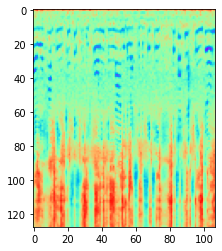

False Negative: 6.0
Epoch [2/100], Step [5100/7699], Loss: 0.000318892911
Epoch [2/100], Step [5200/7699], Loss: 0.000818751170
Epoch [2/100], Step [5300/7699], Loss: 0.011672879569
Epoch [2/100], Step [5400/7699], Loss: 0.004468097817
Epoch [2/100], Step [5500/7699], Loss: 0.000341725769
Epoch [2/100], Step [5600/7699], Loss: 0.000560787681
Epoch [2/100], Step [5700/7699], Loss: 0.000310923089
Epoch [2/100], Step [5800/7699], Loss: 0.002935539000
Epoch [2/100], Step [5900/7699], Loss: 0.001444663969
Epoch [2/100], Step [6000/7699], Loss: 0.000183737400
TRAIN SET
Accuracy: 0.9765625
True Positive: 71.0
True Negative: 179.0
False Positive: 0.0
False Negative: 6.0
TEST SET
Accuracy: 0.953125
True Positive: 17.0
True Negative: 227.0
False Positive: 2.0
False Positive Example:
Score: 0.9999995231628418


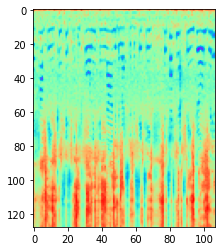

False Positive Example:
Score: 0.9999995231628418


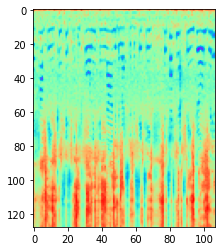

False Negative: 10.0
Epoch [2/100], Step [6100/7699], Loss: 0.020072702318
Epoch [2/100], Step [6200/7699], Loss: 0.000858909916
Epoch [2/100], Step [6300/7699], Loss: 0.000624783861
Epoch [2/100], Step [6400/7699], Loss: 0.000730482920
Epoch [2/100], Step [6500/7699], Loss: 0.000320007268
Epoch [2/100], Step [6600/7699], Loss: 0.003821264952
Epoch [2/100], Step [6700/7699], Loss: 0.000434425456
Epoch [2/100], Step [6800/7699], Loss: 0.000984358951
Epoch [2/100], Step [6900/7699], Loss: 0.000358233403
Epoch [2/100], Step [7000/7699], Loss: 0.002006236929
TRAIN SET
Accuracy: 0.99609375
True Positive: 83.0
True Negative: 172.0
False Positive: 0.0
False Negative: 1.0
TEST SET
Accuracy: 0.98046875
True Positive: 33.0
True Negative: 218.0
False Positive: 1.0
False Positive Example:
Score: 0.9990684390068054


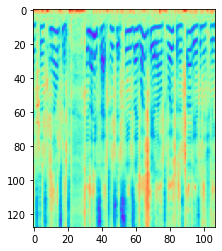

False Negative: 4.0
Epoch [2/100], Step [7100/7699], Loss: 0.000359291793
Epoch [2/100], Step [7200/7699], Loss: 0.000366577995
Epoch [2/100], Step [7300/7699], Loss: 0.007510557771
Epoch [2/100], Step [7400/7699], Loss: 0.000085193155
Epoch [2/100], Step [7500/7699], Loss: 0.005210997071
Epoch [2/100], Step [7600/7699], Loss: 0.000319744111
Epoch [3/100], Step [100/7699], Loss: 0.000073717682
Epoch [3/100], Step [200/7699], Loss: 0.001103383722
Epoch [3/100], Step [300/7699], Loss: 0.000751157175
Epoch [3/100], Step [400/7699], Loss: 0.000325075758
Epoch [3/100], Step [500/7699], Loss: 0.000064868829
Epoch [3/100], Step [600/7699], Loss: 0.000109685483
Epoch [3/100], Step [700/7699], Loss: 0.008542757481
Epoch [3/100], Step [800/7699], Loss: 0.000551178819
Epoch [3/100], Step [900/7699], Loss: 0.001473760116
Epoch [3/100], Step [1000/7699], Loss: 0.000014972046
TRAIN SET
Accuracy: 0.984375
True Positive: 72.0
True Negative: 180.0
False Positive: 0.0
False Negative: 4.0
TEST SET
Accura

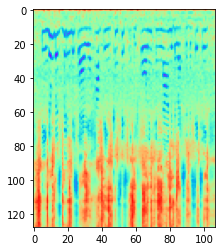

False Negative: 4.0
Epoch [3/100], Step [3100/7699], Loss: 0.000088202600
Epoch [3/100], Step [3200/7699], Loss: 0.000233541854
Epoch [3/100], Step [3300/7699], Loss: 0.002188001061


KeyboardInterrupt: 

In [10]:
# training
def analyse_predictions(title, predictions, labels, audio, spectograms, outputs,
                        show_false_negatives = False, show_false_positives = True):
        correct = torch.sum(predictions == labels)
        total = labels.shape[0]
        true_pos = (predictions == labels) * labels
        true_neg = (predictions == labels) * -(labels-1)
        false_pos = (predictions != labels) * -(labels-1)
        false_neg = (predictions != labels) * labels
        true_pos_sum = torch.sum(true_pos)
        true_neg_sum = torch.sum(true_neg)
        false_pos_sum = torch.sum(false_pos)
        false_neg_sum = torch.sum(false_neg)
        false_pos_index = false_pos.nonzero(as_tuple=False)
        false_neg_index = false_neg.nonzero(as_tuple=False)
        accuracy = correct / total
        print(title)
        print(f'Accuracy: {accuracy}')
        print(f'True Positive: {true_pos_sum}')
        print(f'True Negative: {true_neg_sum}')
        print(f'False Positive: {false_pos_sum}')
        if show_false_positives:
            for idx in false_pos_index:
                print('False Positive Example:')
                print(f'Score: {outputs[idx[0]].item()}')
                spect = spectograms[idx[0]].squeeze(0).to('cpu')
                plt.imshow(spect, cmap='rainbow_r')
                plt.show()
                if torch.is_tensor(audio[idx[0]]):
                    IPython.display.display(Audio(data=audio[idx[0]], rate=sr))
        print(f'False Negative: {false_neg_sum}')
        if show_false_negatives:
            for idx in false_neg_index:
                print('False Negative Example:')
                print(f'Score: {outputs[idx[0]].item()}')
                spect = spectograms[idx[0]].squeeze(0).to('cpu')
                plt.imshow(spect, cmap='rainbow_r')
                plt.show()
                IPython.display.display(Audio(data=audio[idx[0]], rate=sr))

model.train()
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (spectograms, audio, labels) in enumerate(train_loader):  
        spectograms = spectograms.reshape(-1, sequence_length, input_size).to(DEVICE)
        labels = torch.unsqueeze(labels,1).float().to(DEVICE)
        
        # Forward pass
        outputs = model(spectograms)
        loss = criterion(outputs, labels)
    
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print('=======================================================================================')
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.12f}')
            if (i+1) % 1000 == 0:
                
                # How are we doing against a batch of the training set?
                model.eval()
                (spectograms, audio, labels) = next(iter(train_loader))
                spect_plots = spectograms
                spectograms = spectograms.reshape(-1, sequence_length, input_size).to(DEVICE)
                labels = torch.unsqueeze(labels,1).float().to(DEVICE)
                outputs = model(spectograms)
                predictions = (outputs>threshold).float()
                analyse_predictions('TRAIN SET', predictions, labels, audio, spect_plots, outputs,
                                    show_false_positives = False, show_false_negatives = False)

                # How are we doing against a batch of the test set?
                (spectograms, audio, labels) = next(iter(test_loader))
                spect_plots = spectograms
                spectograms = spectograms.reshape(-1, sequence_length, input_size).to(DEVICE)
                labels = torch.unsqueeze(labels,1).float().to(DEVICE)
                outputs = model(spectograms)
                predictions = (outputs>threshold).float()
                analyse_predictions('TEST SET', predictions, labels, audio, spect_plots, outputs,
                                   show_false_positives = True, show_false_negatives = False)
                model.train()

                # save model state
                torch.save(model.state_dict(), model_file)